# IMC breast cancer

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Danenberg et al., Nature Genetics, 2023](https://doi.org/10.1038/s41588-022-01041-y) "Breast tumor microenvironment structures are associated with genomic features and clinical outcome".  
Here 693 tumors of breast cancer were processed with the [Imaging Mass Cytometry](https://doi.org/10.1038/s43018-020-0026-6) method (cytometry by time of fligh, CyTOF) to produce maps of 37 proteins and study the relationship between cell types in tumors with respect to survival.  

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [4]:
RUN_LONG = False

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://zenodo.org/records/7324285  
Images are available here: https://zenodo.org/records/6036188

In [5]:
data_dir = Path("../data/raw/IMC_Breast_cancer_Danenberg_2022")
objects_path = data_dir / "SingleCells.csv"

if objects_path.with_suffix('.parquet').exists():
    obj = pd.read_parquet(objects_path.with_suffix('.parquet'))
else:
    obj = pd.read_csv(objects_path)
    # for latter use
    obj.to_parquet(objects_path.with_suffix('.parquet'))
obj

ImageNumber  ObjectNumber metabric_id           cellPhenotype  \
0                  1             1     MB-0282         CK^{med}ER^{lo}   
1                  1             2     MB-0282       ER^{hi}CXCL12^{+}   
2                  1             4     MB-0282  CD4^{+} T cells & APCs   
3                  1             5     MB-0282         CK^{med}ER^{lo}   
4                  1             7     MB-0282         CD4^{+} T cells   
...              ...           ...         ...                     ...   
1123461          797          3818     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123462          797          3819     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123463          797          3820     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123464          797          3822     MB-0406          CK^{lo}ER^{lo}   
1123465          797          3823     MB-0406             Fibroblasts   

         is_epithelial  is_tumour  is_normal  is_dcis  is_interface  \
0                    1          1          0        0             1   
1                    1          1          0        0             1   
2                    0          1          0        0             0   
3                    1          1          0        0             0   
4                    0          1          0        0             1   
...                ...        ...        ...      ...           ...   
1123461              1          1          0        0             0   
1123462              1          1          0        0             0   
1123463              1          1          0        0             1   
1123464              1          1          0        0             1   
1123465              0          1          0        0             0   

         is_perivascular  ...  CD31-vWF    CXCL12   HLA-ABC      panCK  \
0                      0  ...  0.495330  0.401104  9.282180  18.180412   
1                      0  ...  0.552035  2.567602  1.417755  48.593726   
2                      0  ...  0.493669  0.117742  3.791699   3.404438   
3                      0  ...  0.373286  1.048929  2.364418  23.289196   
4                      0  ...  0.287512  0.058795  4.690886   0.664581   
...                  ...  ...       ...       ...       ...        ...   
1123461                0  ...  0.412993  7.255870  0.947830  76.300971   
1123462                0  ...  0.609522  3.370633  1.534348  53.953806   
1123463                0  ...  0.562381  2.553417  0.629895  41.573201   
1123464                0  ...  0.133439  0.019060  1.156061   0.053584   
1123465                0  ...  0.218254  0.054445  1.138097   0.333484   

         c-Caspase3       DNA1       DNA2  Location_Center_X  \
0          0.163026  29.445302  54.989698         121.418605   
1          0.310149  23.160734  42.596685         150.468531   
2          0.242591  16.884008  31.325295         221.930233   
3          0.297700   8.475436  15.654673         354.136364   
4          0.078051  14.009167  28.587826         469.174603   
...             ...        ...        ...                ...   
1123461    0.000000  16.235925  31.912625         482.950000   
1123462    0.205527   7.448000  12.347708         605.791667   
1123463    0.187847   9.222450  18.821950         833.200000   
1123464    0.000000   3.641944   7.286806         851.916667   
1123465    0.000000  10.869333  21.537233         748.466667   

         Location_Center_Y  AreaShape_Area  
0                 4.023256              43  
1                 6.083916             143  
2                 5.139535             129  
3                 5.890909             110  
4                 7.158730             126  
...                    ...             ...  
1123461         947.825000              40  
1123462         945.333333              24  
1123463         947.350000              20  
1123464         949.222222              36  
1123465         949.733333              30  

[1123466 rows x 53 columns]

`ObjectNumber` is the ID of cells, starting at 1 for each image (there are 797 ObjectNumber = 1).

In [6]:
obj.rename(columns={'Location_Center_X': 'x', 'Location_Center_Y': 'y'}, inplace=True)
sample_cols = ['ImageNumber', 'ObjectNumber', 'metabric_id']
# this file contains 'c-Caspase3c-PARP' instead of 'c-Caspase3c' as in the dataframe
# all_epitopes = pd.read_csv(data_dir / 'markerStackOrder.csv').iloc[:, 1].values
# so instead we directly do:
all_epitopes = obj.columns[11:50].values
# remove Histone H3 and DNA markers
marker_cols = list(all_epitopes[1:-2])
pos_cols = ['x', 'y']
cell_type_cols = [
    'is_epithelial',
    'is_tumour',
    'is_normal',
    'is_dcis',
    'is_interface',
    'is_perivascular',
    'is_hotAggregate',
    ]
sample_col = 'ImageNumber'  # != from `sample_cols`
patient_col = 'metabric_id'
pheno_col = 'cellPhenotype'
nb_phenotypes = obj[pheno_col].unique().size
all_cols = sample_cols + marker_cols + pos_cols + cell_type_cols + [pheno_col]
# columns we want to include in network data
net_cols = pos_cols + [pheno_col] + cell_type_cols + marker_cols

print(f'nb phenotypes: {nb_phenotypes}')
print(f'nb used markers: {len(marker_cols)}')

nb phenotypes: 32
nb used markers: 36


In [7]:
# # Load published network
# neighbs = pd.read_csv(data_dir / 'CellNeighbours.csv')

In [13]:
# Show number of cells per sample
sample_sizes = obj[['ImageNumber', 'ObjectNumber']].groupby(['ImageNumber']).count()
sample_sizes

ObjectNumber
ImageNumber              
1                    1624
2                    1057
3                    1648
4                    1348
5                    2018
...                   ...
793                   372
794                  4460
795                  2689
796                   737
797                  3758

[794 rows x 1 columns]

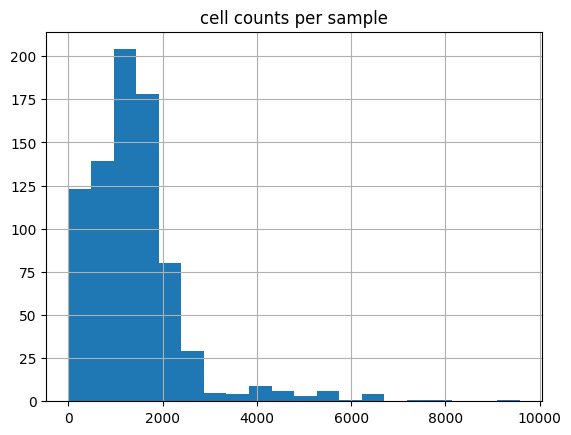

In [14]:
axes = sample_sizes.hist(bins=20)
axes[0][0].set_title('cell counts per sample');

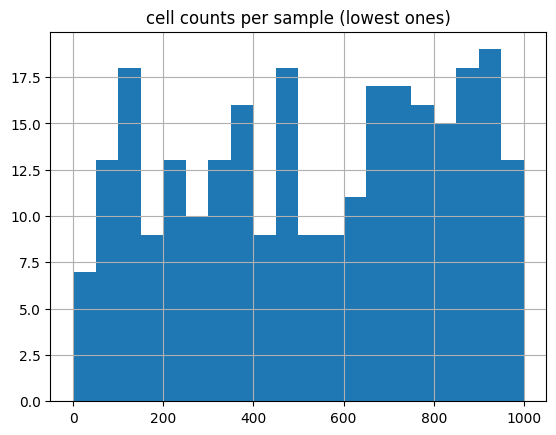

In [15]:
axes = sample_sizes.hist(bins=20, range=(0, 1000))
axes[0][0].set_title('cell counts per sample (lowest ones)');

We may need to discard patients with too few cells, we'll manually inspect reconstructed networks to define a size threshold latter in this notebook.

In [16]:
# aggregate unique pairs of patients and image IDs
counts = obj[sample_cols].groupby([sample_col, patient_col]).count()
print(counts)

# count occurrences of patient IDs in patient / image pairs
occ = counts.index.get_level_values(1).value_counts()
print(occ)

n_patient_multiple = np.sum(occ.values != 1)
print(f'There are {n_patient_multiple} patients with multiple samples')

                         ObjectNumber
ImageNumber metabric_id              
1           MB-0282              1624
2           MB-0099              1057
3           MB-0598              1648
4           MB-0606              1348
5           MB-0190              2018
...                               ...
793         MB-0359               372
794         MB-0353              4460
795         MB-0158              2689
796         MB-0158               737
797         MB-0406              3758

[794 rows x 1 columns]
metabric_id
MB-0359    4
MB-0135    3
MB-0175    3
MB-0145    3
MB-0184    3
          ..
MB-0180    1
MB-0181    1
MB-0182    1
MB-0183    1
MB-0129    1
Name: count, Length: 718, dtype: int64
There are 59 patients with multiple samples


### Survival data

From the authors:
> Processed metadata from the METABRIC study are among the files provided.  It is, however, recommended that additional analyses that rely on METABRIC metadata, use data downloaded from their original publications or a public repository as these data are subject to updates, and the user may wish to process them differently.

In [17]:
survival_path = data_dir / "IMCClinical.csv"
surv = pd.read_csv(survival_path, index_col=0)
surv

ERStatus LymphNodesOrdinal sizeOrdinal  Grade ERBB2_pos  \
metabric_id                                                           
MB-0000          pos                7+     20-50mm    3.0     False   
MB-0002          pos                 0      5-10mm    3.0     False   
MB-0005          pos                 1     10-20mm    2.0     False   
MB-0006          pos               2-3     20-50mm    2.0     False   
MB-0008          pos                7+     20-50mm    3.0     False   
...              ...               ...         ...    ...       ...   
MB-3824          pos                 0     20-50mm    3.0     False   
MB-3838          pos                 0     20-50mm    3.0     False   
MB-3854          neg                 0     10-20mm    1.0     False   
MB-3876          neg                 0     20-50mm    3.0       NaN   
MB-3978          neg                 0     10-20mm    3.0      True   

             yearsToStatus  DeathBreast  isValidation        PAM50  \
metabric_id                                                          
MB-0000          11.540041            0         False  Normal-like   
MB-0002           6.951403            0         False    Luminal A   
MB-0005          13.445585            1         False    Luminal B   
MB-0006          13.546886            0         False    Luminal B   
MB-0008           3.397673            1         False    Luminal B   
...                    ...          ...           ...          ...   
MB-3824          10.387406            1          True    Luminal B   
MB-3838          11.044490            1          True    Luminal B   
MB-3854           8.150582            0          True    Luminal A   
MB-3876           1.612594            1         False          NaN   
MB-3978           8.284736            1          True         HER2   

                IntClust  
metabric_id               
MB-0000      IntClust 4+  
MB-0002      IntClust 4+  
MB-0005       IntClust 3  
MB-0006       IntClust 9  
MB-0008       IntClust 9  
...                  ...  
MB-3824       IntClust 2  
MB-3838       IntClust 8  
MB-3854       IntClust 3  
MB-3876              NaN  
MB-3978      IntClust 5-  

[709 rows x 10 columns]

### Discard small samples

In [18]:
smallest_samples = sample_sizes.sort_values('ObjectNumber') #.head(20)

if RUN_LONG:
    for sample_name in smallest_samples.index[:100]:
        print("    processing sample {}".format(sample_name))
        select_sample = obj[sample_col] == sample_name
        nodes = obj.loc[select_sample, all_cols]
        coords = nodes[pos_cols].values
        pairs = ty.build_delaunay(
            coords, 
            node_adaptive_trimming=True, 
            n_edges=3, 
            trim_dist_ratio=2,
            min_dist=0, 
            trim_dist=trim_dist,
            )
        print("    ", end="")

        if min_neighbors > 0:
            pairs = ty.link_solitaries(
                coords, 
                pairs, 
                min_neighbors=min_neighbors,
                )
        distances = ty.distance_neighbors(coords, pairs)

        sample_size = len(coords)
        fig, ax = ty.plot_network(
            coords, pairs, labels=nodes[pheno_col],
            color_mapper=celltypes_color_mapper, 
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.2, 0.5)}
            )
        plt.axis('off');
        title = f"network_sample-{sample_name}"
        ax.set_title(f"patient: {patient_id}   sample: {sample_name}   size: {sample_size}")
        plt.show()

We discard samples with less than 150 cells.

In [19]:
net_size_threshold = 150

select = sample_sizes['ObjectNumber'] >= net_size_threshold
print(f"there are {select.sum()} samples with > {net_size_threshold} cells, disarding {len(select) - select.sum()} samples")
sample_sizes = sample_sizes.loc[select, :]
uniq_samples = sample_sizes.index.values

print(f"filtering small samples, full dataframe dropping from {len(obj)} cells to", end=' ')
obj = obj.query("ImageNumber in @uniq_samples")
print(f'{len(obj)} cells')

print(f"survival data dropping from {len(surv)} patients to", end=' ')
uniq_patients = obj['metabric_id'].unique()
surv = surv.query("metabric_id in @uniq_patients")
print(f'{len(surv)} patients')

there are 756 samples with > 150 cells, disarding 38 samples
filtering small samples, full dataframe dropping from 1123466 cells to 1120100 cells
survival data dropping from 709 patients to 672 patients


## Spatial networks reconstruction

### Load one sample

We will have a look at the spatial networks of different samples from the same patient to check they seem "correct", i.e. not over nor under connected.

In [20]:
# make common color mapper
cycle_cmap = False

nodes_labels = obj[pheno_col]
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = nodes_labels.max()
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    celltypes_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

processing sample 59
there are 1/301 nodes with < 3 edges
processing sample 150
there are 2/1060 nodes with < 3 edges
processing sample 790
there are 4/3598 nodes with < 3 edges
processing sample 793
there are 4/372 nodes with < 3 edges


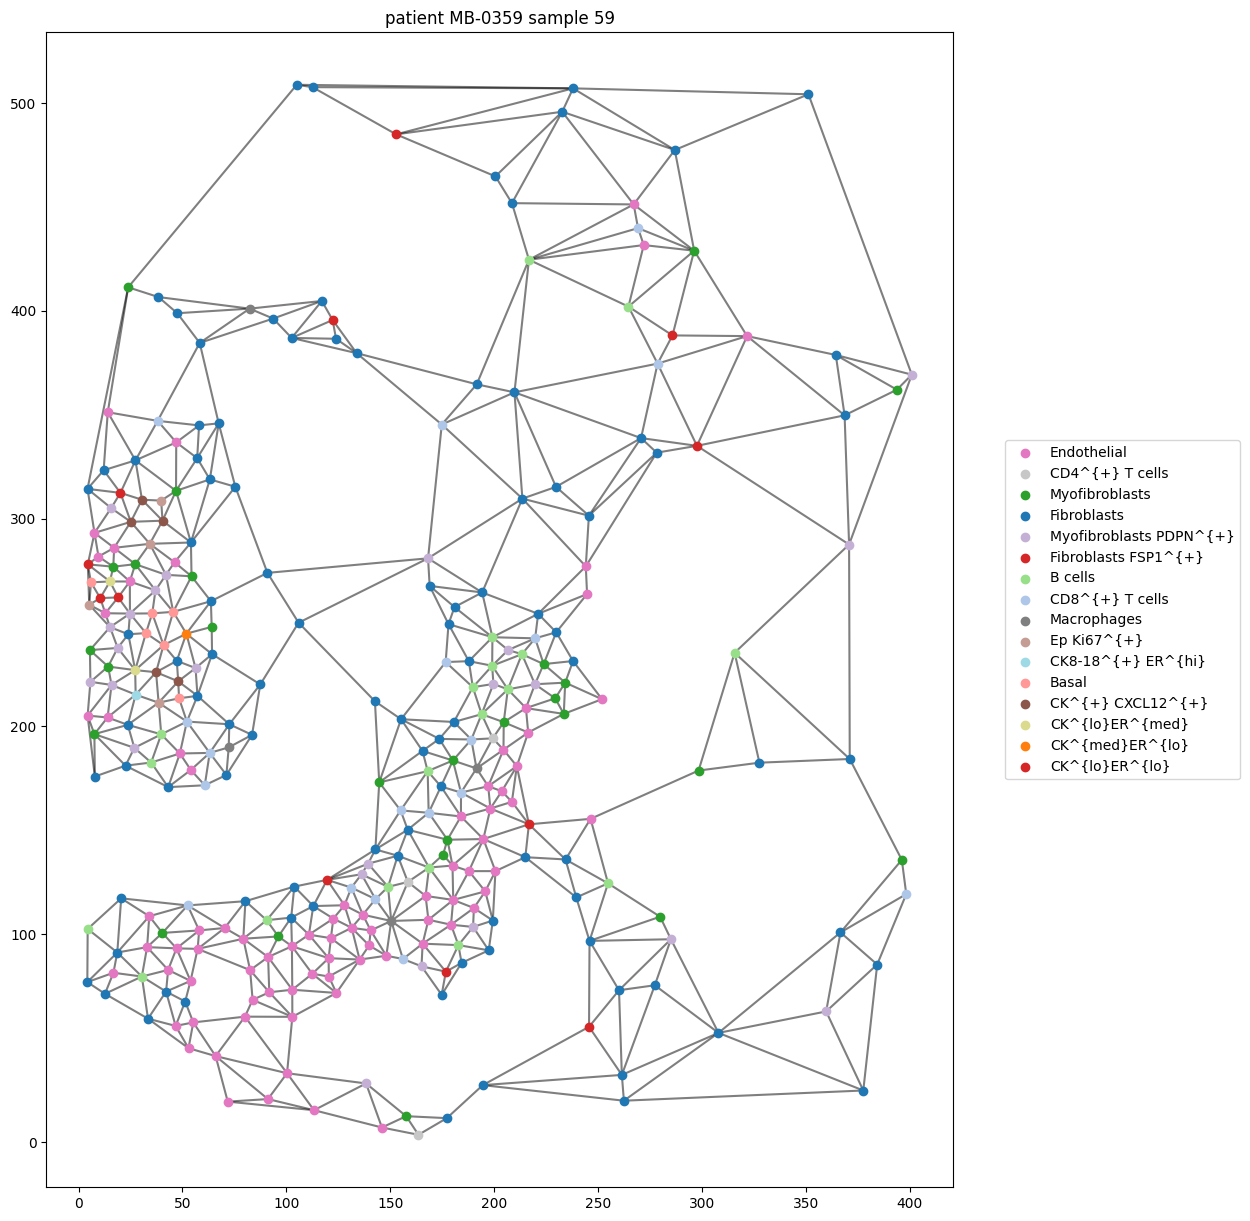

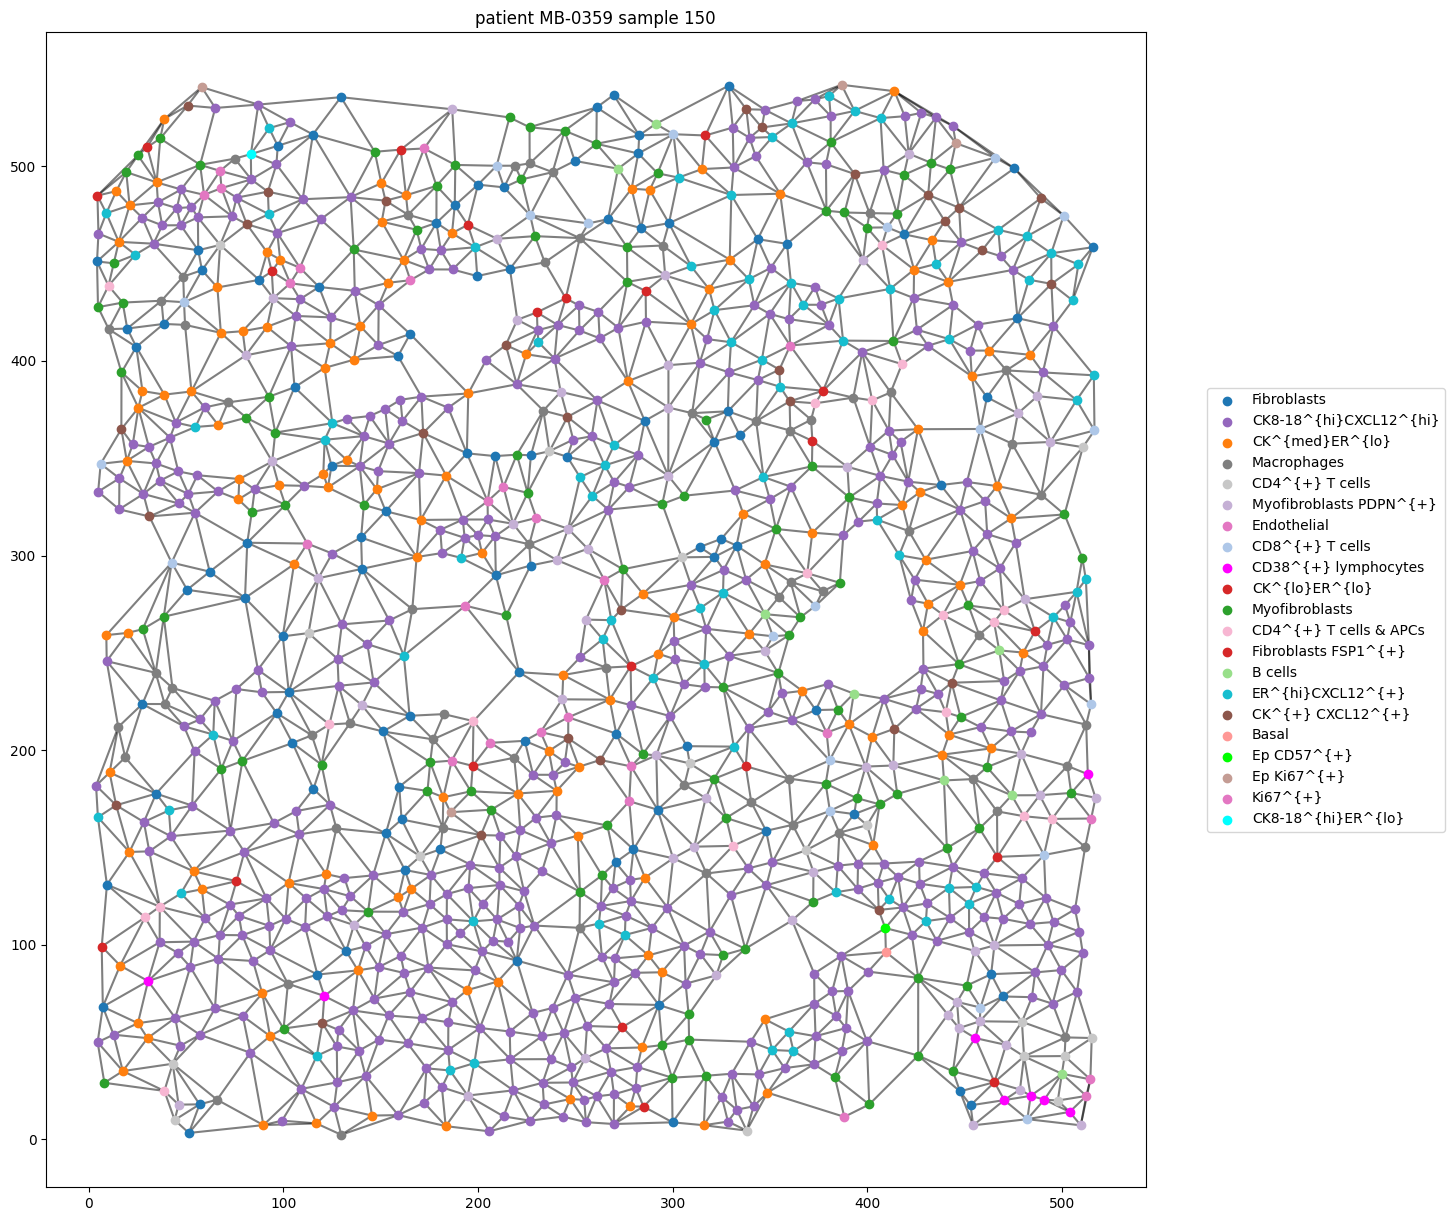

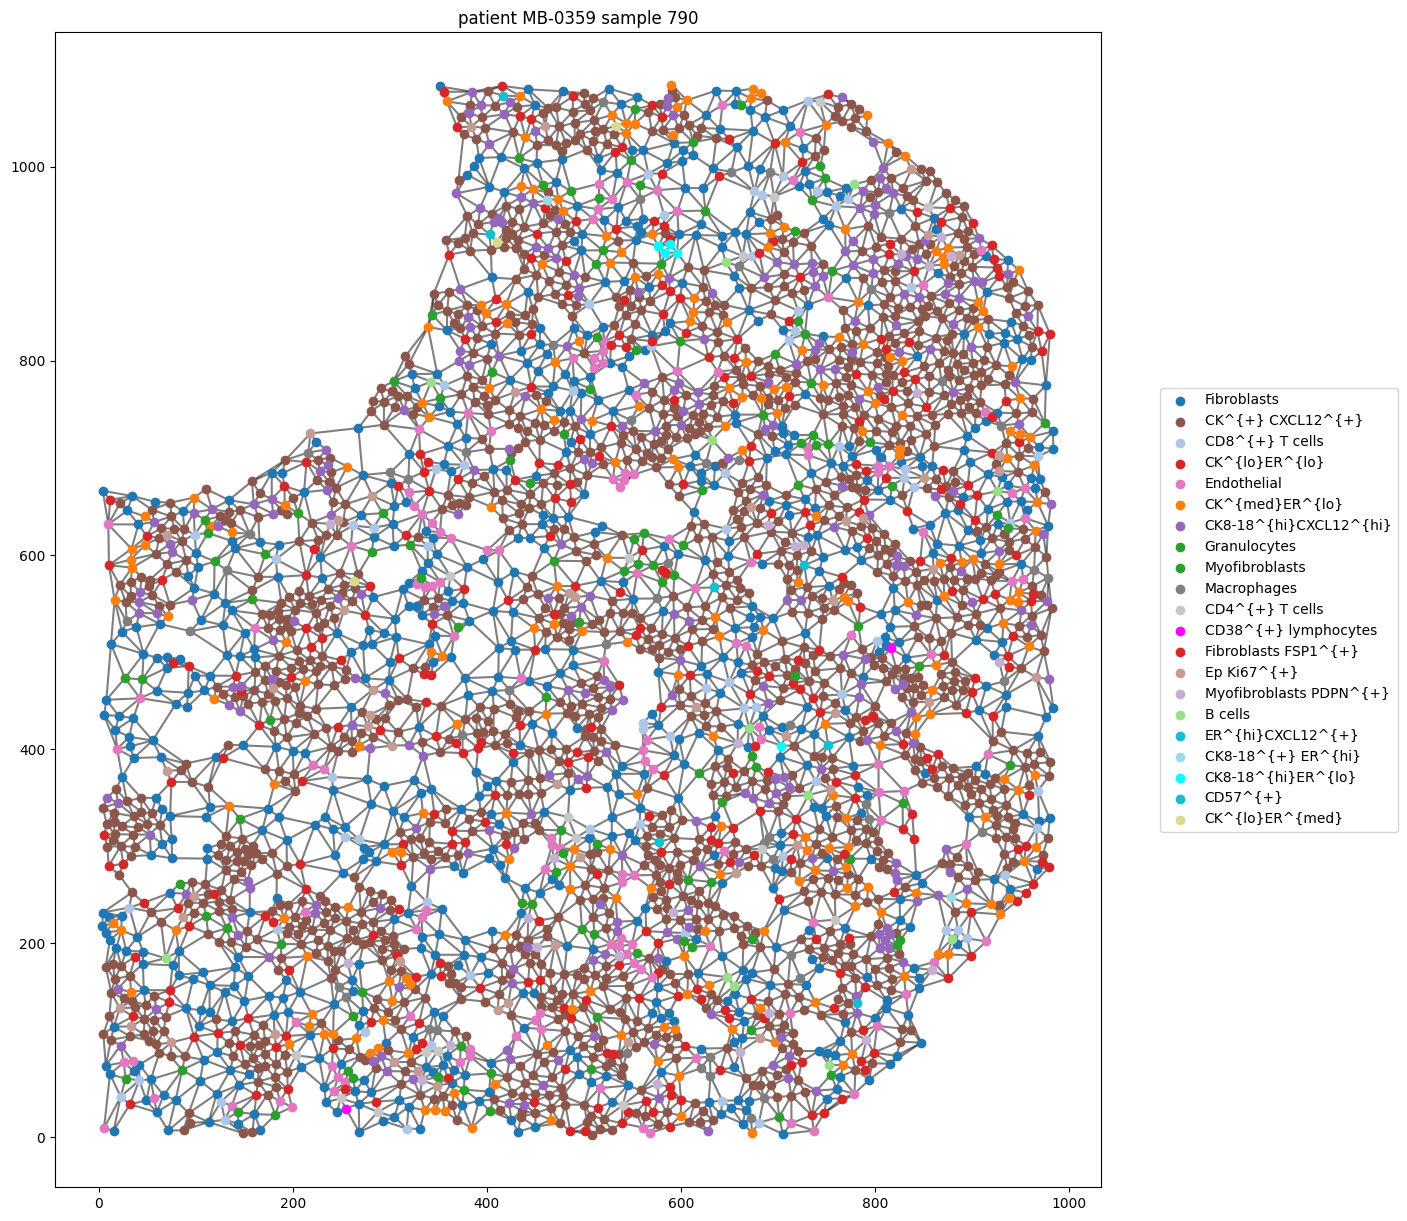

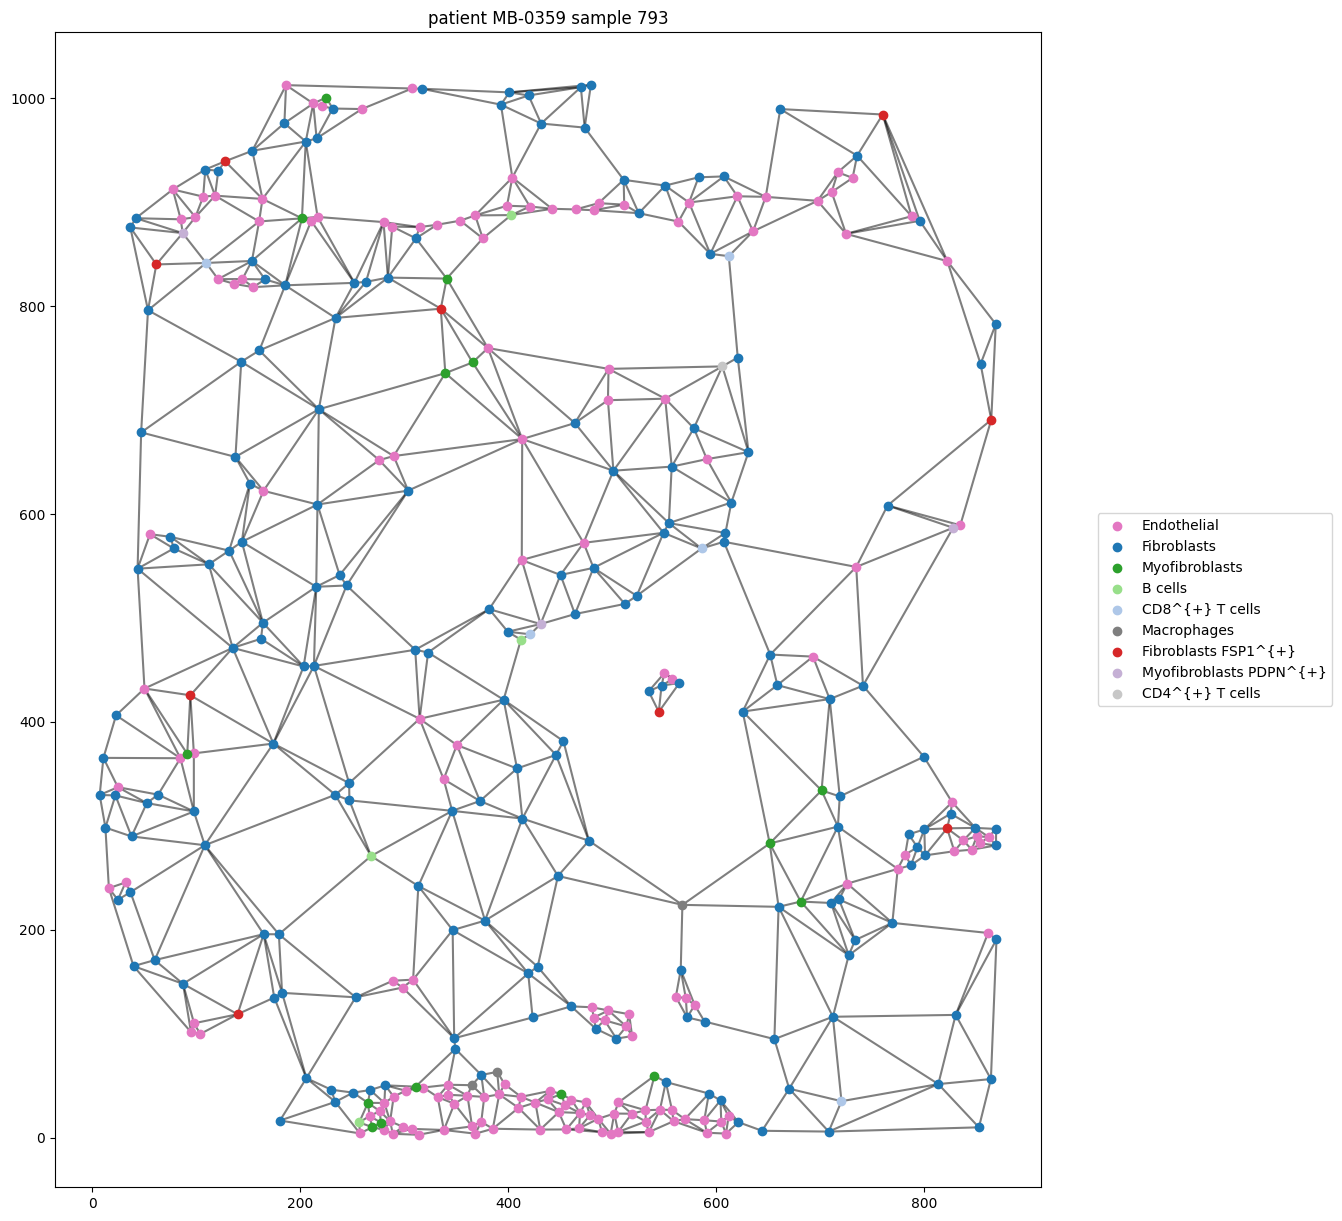

In [57]:
patient_id = 'MB-0359'  # this person has 4 samples
select_patient = obj[patient_col] == patient_id
sample_names = obj.loc[select_patient, sample_col].unique()  # look for the several samples per patient
for sample_name in sample_names:
    print("processing sample {}".format(sample_name))
    select_sample = obj[sample_col] == sample_name
    nodes = obj.loc[select_patient & select_sample, net_cols]
    coords = nodes[pos_cols].values
    pairs = ty.build_delaunay(coords)
    # we want to avoid isolated cells, so we link them to their 3 closest neighbors
    pairs = ty.link_solitaries(coords, pairs, method='delaunay', min_neighbors=3)

    fig, ax = ty.plot_network(
        coords, pairs, labels=nodes[pheno_col],
        color_mapper=celltypes_color_mapper, 
        legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
        )
    plt.title("patient {} sample {}".format(patient_id, sample_name))

### All samples network reconstruction

#### Plot spatial networks

In [21]:
processed_dir = Path('../data/processed/IMC_breast_cancer')
dir_fig_save = processed_dir / 'figures'

In [22]:
# Choose optimal distance threshold for edge trimming

trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

save_dir = processed_dir / f"samples_networks_xy_choose_distance_trim_dist-{trim_dist}_solitary-{min_neighbors}"
save_dir.mkdir(parents=True, exist_ok=True)

# use few networks
samples_dst = obj[sample_col].unique()[:10]

if RUN_LONG:
    for sample_name in samples_dst:
        print("    processing sample {}".format(sample_name))
        select_sample = obj[sample_col] == sample_name
        nodes = obj.loc[select_sample, all_cols]
        coords = nodes[pos_cols].values
        pairs = ty.build_delaunay(
            coords, 
            node_adaptive_trimming=True, 
            n_edges=3, 
            trim_dist_ratio=2,
            min_dist=0, 
            trim_dist=trim_dist,
            )
        print("    ", end="")

        if min_neighbors > 0:
            pairs = ty.link_solitaries(
                coords, 
                pairs, 
                min_neighbors=min_neighbors,
                )
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes[pheno_col],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.2, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_sample-{sample_name}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [23]:
trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

reconst_dir = processed_dir / f"samples_networks_xy_min_size-{net_size_threshold}_solitary-{min_neighbors}"
save_dir = reconst_dir / "networks_images_common_cmap_saturated_first"
save_dir.mkdir(parents=True, exist_ok=True)

In [24]:
if RUN_LONG:
    for patient_id in uniq_patients:
        print(f"processing patient {patient_id}")
        select_patient = obj[patient_col] == patient_id
        samples = obj.loc[select_patient, sample_col].unique()
        for sample in samples:
            print(f"    processing sample {sample}")
            select_sample = obj[sample_col] == sample
            nodes = obj.loc[select_patient & select_sample, all_cols]
            coords = nodes[pos_cols].values
            pairs = ty.build_delaunay(
                coords, 
                node_adaptive_trimming=True, 
                n_edges=3, 
                trim_dist_ratio=2,
                min_dist=0, 
                trim_dist=trim_dist,
                )
            
            if min_neighbors > 0:
                pairs = ty.link_solitaries(
                    coords, 
                    pairs, 
                    min_neighbors=min_neighbors,
                    )

            fig, ax = ty.plot_network(coords, pairs, labels=nodes[pheno_col],
                                      color_mapper=celltypes_color_mapper, 
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"patient-{patient_id}_sample-{sample}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [25]:
# Probably want to avoid this strategy

# if RUN_LONG:
#     edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
#     # number of nodes previously seen
#     nb_nodes = 0
#     for patient_id in uniq_patients:
#         print(f"processing patient {patient_id}")
#         select_patient = obj[patient_col] == patient_id
#         samples = obj.loc[select_patient, sample_col].unique()
#         for sample in samples:
#             print(f"    processing sample {sample}")
#             select_sample = obj[sample_col] == sample
#             nodes = obj.loc[select_patient & select_sample, all_cols]
#             coords = nodes[pos_cols].values
#             pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
#             # print("    ", end="")
#             if k_sol > 0:
#                 pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

#             # increase ids in pairs by the number of nodes in all previously loaded networks
#             pairs = pairs + nb_nodes
#             edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
#             edges['filename'] = filename
#             # update number of nodes for next network
#             nb_nodes = nb_nodes + coords.shape[0]
#             edges_all = pd.concat([edges_all, edges], ignore_index=True)
#     edges_all.to_csv(reconst_dir / 'sample_all-edges.csv', index=False)
# else:
#     edges_all = pd.read_csv(reconst_dir / 'sample_all-edges.csv')

In [26]:
# save networks in separate files
if RUN_LONG:
    for patient_id in uniq_patients:
        print(f"processing patient {patient_id}")
        select_patient = obj[patient_col] == patient_id
        samples = obj.loc[select_patient, sample_col].unique()
        for sample in samples:
            print(f"    processing sample {sample}")
            select_sample = obj[sample_col] == sample
            nodes = obj.loc[select_patient & select_sample, pos_cols]
            coords = nodes[pos_cols].values
            pairs = ty.build_delaunay(
                coords, 
                node_adaptive_trimming=True, 
                n_edges=3, 
                trim_dist_ratio=2,
                min_dist=0, 
                trim_dist=trim_dist,
                )
            
            if min_neighbors > 0:
                pairs = ty.link_solitaries(
                    coords, 
                    pairs, 
                    min_neighbors=min_neighbors,
                    )

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_parquet(reconst_dir / f'edges_sample-{sample}.parquet', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, or "niches", potentially predictive of response to therapy.

### Cell types proportions

In [27]:
# we add attributes to nodes to color network figures
nodes_all = obj[pos_cols + [pheno_col]].copy()
nodes_all = nodes_all.join(pd.get_dummies(obj[pheno_col]))
uniq_phenotypes = nodes_all[pheno_col].unique()  # 'attribute_uniq' in other notebooks

In [28]:
# here we don't use `sample_col` but `patient_col` in the group / unstack procedure to aggregate 
# statistics per patient and condition rather than per sample.

count_types = obj[[patient_col, pheno_col, sample_col]].groupby([patient_col, pheno_col]).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient.csv')
count_types

cellPhenotype  B cells  Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                     
MB-0000              1      0         0                     0   
MB-0002              0      0         1                     0   
MB-0005              1      0       706                     0   
MB-0006              1     17         0                     5   
MB-0010              1      0         2                     6   
...                ...    ...       ...                   ...   
MB-3824              3      1        20                     3   
MB-3838              0      0       130                     0   
MB-3854              0      1        85                     0   
MB-3876             17      1         9                     4   
MB-3978              5     57       172                     2   

cellPhenotype  CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                        
MB-0000                      0                       0         0   
MB-0002                      2                       0         0   
MB-0005                      0                       0         0   
MB-0006                      4                       0         0   
MB-0010                     13                       5         0   
...                        ...                     ...       ...   
MB-3824                      5                       0         0   
MB-3838                      1                       0         2   
MB-3854                     11                       0         0   
MB-3876                      6                      82         0   
MB-3978                     53                       1         0   

cellPhenotype  CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  \
metabric_id                                                                  
MB-0000                      4                   1                      10   
MB-0002                      7                   0                     892   
MB-0005                     11                   1                      19   
MB-0006                      4                   0                      94   
MB-0010                      8                1018                       0   
...                        ...                 ...                     ...   
MB-3824                      1                   0                       3   
MB-3838                      9                   0                      14   
MB-3854                     15                   1                       7   
MB-3876                     95                   0                       8   
MB-3978                     76                   0                       0   

cellPhenotype  ...  HER2^{+}  Ki67^{+}  MHC I & II^{hi}  MHC I^{hi}CD57^{+}  \
metabric_id    ...                                                            
MB-0000        ...         0         0                0                   0   
MB-0002        ...         0         0                0                   0   
MB-0005        ...         3         0                0                   0   
MB-0006        ...         0         0                0                   0   
MB-0010        ...         0         3                7                   1   
...            ...       ...       ...              ...                 ...   
MB-3824        ...         1         0                0                   0   
MB-3838        ...         0         0                0                   0   
MB-3854        ...         0         0                0                   0   
MB-3876        ...        75         2               46                   0   
MB-3978        ...       304         0                3                   0   

cellPhenotype  MHC^{hi}CD15^{+}  Macrophages  Macrophages & granulocytes  \
metabric_id                                                                
MB-0000                       0            3                           0  

Instead of counts we use proportions of cell types per patient and condition.

In [29]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

cellPhenotype   B cells     Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                         
MB-0000        0.003968  0.000000  0.000000              0.000000   
MB-0002        0.000000  0.000000  0.000473              0.000000   
MB-0005        0.000641  0.000000  0.452854              0.000000   
MB-0006        0.001235  0.020988  0.000000              0.006173   
MB-0010        0.000716  0.000000  0.001433              0.004298   
...                 ...       ...       ...                   ...   
MB-3824        0.005736  0.001912  0.038241              0.005736   
MB-3838        0.000000  0.000000  0.275424              0.000000   
MB-3854        0.000000  0.002342  0.199063              0.000000   
MB-3876        0.014120  0.000831  0.007475              0.003322   
MB-3978        0.003514  0.040056  0.120871              0.001405   

cellPhenotype  CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                        
MB-0000               0.000000                0.000000  0.000000   
MB-0002               0.000946                0.000000  0.000000   
MB-0005               0.000000                0.000000  0.000000   
MB-0006               0.004938                0.000000  0.000000   
MB-0010               0.009312                0.003582  0.000000   
...                        ...                     ...       ...   
MB-3824               0.009560                0.000000  0.000000   
MB-3838               0.002119                0.000000  0.004237   
MB-3854               0.025761                0.000000  0.000000   
MB-3876               0.004983                0.068106  0.000000   
MB-3978               0.037245                0.000703  0.000000   

cellPhenotype  CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  \
metabric_id                                                                  
MB-0000               0.015873            0.003968                0.039683   
MB-0002               0.003310            0.000000                0.421749   
MB-0005               0.007056            0.000641                0.012187   
MB-0006               0.004938            0.000000                0.116049   
MB-0010               0.005731            0.729226                0.000000   
...                        ...                 ...                     ...   
MB-3824               0.001912            0.000000                0.005736   
MB-3838               0.019068            0.000000                0.029661   
MB-3854               0.035129            0.002342                0.016393   
MB-3876               0.078904            0.000000                0.006645   
MB-3978               0.053408            0.000000                0.000000   

cellPhenotype  ...  HER2^{+}  Ki67^{+}  MHC I & II^{hi}  MHC I^{hi}CD57^{+}  \
metabric_id    ...                                                            
MB-0000        ...  0.000000  0.000000         0.000000            0.000000   
MB-0002        ...  0.000000  0.000000         0.000000            0.000000   
MB-0005        ...  0.001924  0.000000         0.000000            0.000000   
MB-0006        ...  0.000000  0.000000         0.000000            0.000000   
MB-0010        ...  0.000000  0.002149         0.005014            0.000716   
...            ...       ...       ...              ...                 ...   
MB-3824        ...  0.001912  0.000000         0.000000            0.000000   
MB-3838        ...  0.000000  0.000000         0.000000            0.000000   
MB-3854        ...  0.000000  0.000000         0.000000            0.000000   
MB-3876        ...  0.062292  0.001661         0.038206            0.000000   
MB-3978        ...  0.213633  0.000000         0.002108            0.000000   

cellPhenotype  MHC^{hi}CD15^{+}  Macrophages  Macrophages & granulocytes  \
metabric_id                                                                
MB-0000               

In [31]:
surv_orig = surv.copy()
surv = surv.loc[~surv['isValidation'], :]
surv.drop(columns=['isValidation'], inplace=True)

/var/folders/yr/dhxfwx0d05s3zq1k3ng_f2j40000gp/T/ipykernel_4780/708953463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surv.drop(columns=['isValidation'], inplace=True)


In [32]:
surv

ERStatus LymphNodesOrdinal sizeOrdinal  Grade ERBB2_pos  \
metabric_id                                                           
MB-0000          pos                7+     20-50mm    3.0     False   
MB-0002          pos                 0      5-10mm    3.0     False   
MB-0005          pos                 1     10-20mm    2.0     False   
MB-0006          pos               2-3     20-50mm    2.0     False   
MB-0010          pos                 0     20-50mm    3.0     False   
...              ...               ...         ...    ...       ...   
MB-3688          pos                 0     20-50mm    3.0       NaN   
MB-3692          pos                 1     20-50mm    3.0       NaN   
MB-3747          pos                 0     20-50mm    2.0       NaN   
MB-3804          neg                 0     20-50mm    3.0       NaN   
MB-3876          neg                 0     20-50mm    3.0       NaN   

             yearsToStatus  DeathBreast        PAM50     IntClust  
metabric_id                                                        
MB-0000          11.540041            0  Normal-like  IntClust 4+  
MB-0002           6.951403            0    Luminal A  IntClust 4+  
MB-0005          13.445585            1    Luminal B   IntClust 3  
MB-0006          13.546886            0    Luminal B   IntClust 9  
MB-0010           0.640657            1    Luminal B   IntClust 7  
...                    ...          ...          ...          ...  
MB-3688           2.179329            1          NaN          NaN  
MB-3692           5.089665            1          NaN          NaN  
MB-3747          18.877481            0          NaN          NaN  
MB-3804          18.754278            0          NaN          NaN  
MB-3876           1.612594            1          NaN          NaN  

[509 rows x 9 columns]

In [61]:
# replace some values with numbers for fitting
mapper_str = {
    'pos': 1,
    'neg': 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERStatus'] = surv['ERStatus'].map(mapper_str)

mapper_bool = {
    True: 1,
    False: 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERBB2_pos'] = surv['ERBB2_pos'].map(mapper_bool)

In [82]:
duration_col = 'yearsToStatus'
event_col = 'DeathBreast'
covariates = ['ERStatus'] #, 'ERBB2_pos'] # else []
drop_last_column = True
drop_nan = True
if drop_last_column:
    df_surv = prop_types.iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = prop_types.join(surv[[duration_col, event_col]], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 672 observations with NaN


In [83]:
df_surv

B cells     Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                       
MB-0000      0.003968  0.000000  0.000000              0.000000   
MB-0002      0.000000  0.000000  0.000473              0.000000   
MB-0005      0.000641  0.000000  0.452854              0.000000   
MB-0006      0.001235  0.020988  0.000000              0.006173   
MB-0010      0.000716  0.000000  0.001433              0.004298   
...               ...       ...       ...                   ...   
MB-3824      0.005736  0.001912  0.038241              0.005736   
MB-3838      0.000000  0.000000  0.275424              0.000000   
MB-3854      0.000000  0.002342  0.199063              0.000000   
MB-3876      0.014120  0.000831  0.007475              0.003322   
MB-3978      0.003514  0.040056  0.120871              0.001405   

             CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                      
MB-0000             0.000000                0.000000  0.000000   
MB-0002             0.000946                0.000000  0.000000   
MB-0005             0.000000                0.000000  0.000000   
MB-0006             0.004938                0.000000  0.000000   
MB-0010             0.009312                0.003582  0.000000   
...                      ...                     ...       ...   
MB-3824             0.009560                0.000000  0.000000   
MB-3838             0.002119                0.000000  0.004237   
MB-3854             0.025761                0.000000  0.000000   
MB-3876             0.004983                0.068106  0.000000   
MB-3978             0.037245                0.000703  0.000000   

             CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  ...  \
metabric_id                                                               ...   
MB-0000             0.015873            0.003968                0.039683  ...   
MB-0002             0.003310            0.000000                0.421749  ...   
MB-0005             0.007056            0.000641                0.012187  ...   
MB-0006             0.004938            0.000000                0.116049  ...   
MB-0010             0.005731            0.729226                0.000000  ...   
...                      ...                 ...                     ...  ...   
MB-3824             0.001912            0.000000                0.005736  ...   
MB-3838             0.019068            0.000000                0.029661  ...   
MB-3854             0.035129            0.002342                0.016393  ...   
MB-3876             0.078904            0.000000                0.006645  ...   
MB-3978             0.053408            0.000000                0.000000  ...   

             MHC I & II^{hi}  MHC I^{hi}CD57^{+}  MHC^{hi}CD15^{+}  \
metabric_id                                                          
MB-0000             0.000000            0.000000          0.000000   
MB-0002             0.000000            0.000000          0.000000   
MB-0005             0.000000            0.000000          0.000000   
MB-0006             0.000000            0.000000          0.000000   
MB-0010             0.005014            0.000716          0.000000   
...                      ...                 ...               ...   
MB-3824             0.000000            0.000000          0.000000   
MB-3838             0.000000            0.000000          0.000000   
MB-3854             0.000000            0.000000          0.000000   
MB-3876             0.038206            0.000000          0.001661   
MB-3978             0.002108            0.000000          0.003514   

             Macrophages  Macrophages & granulocytes  Myofibroblasts  \
metabric_id                                                            
MB-0000         0.011905                    0.000000        0.015873   
MB-0002         0.003783                    0.000000        0.135697   
MB-0005         0.005131      

In [84]:
cph = CoxPHFitter()
cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=['ERStatus'])

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

/Users/Alexis/.pyenv/versions/3.10.13/envs/test/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Fibroblasts FSP1^{+}', 'Ki67^{+}'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 657 total observations, 443 right-censored observations>
             duration col = 'yearsToStatus'
                event col = 'DeathBreast'
                   strata = ERStatus
      baseline estimation = breslow
   number of observations = 657
number of events observed = 214
   partial log-likelihood = -1118.76
         time fit was run = 2024-02-23 16:28:16 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
B cells                      4.74    114.69      8.61          -12.14           21.62                0.00            2.46e+09
Basal                        5.04    155.00      8.46          -11.54           21.63                0.00            2.47e+09
CD15^{+}                     6.09    441.83      8.45          -10.47           22.66                0.00            6.91e+09
CD38^{+} lymphocytes         4.59     98.76      9.05          -13.14           22.33                0.00            4.97e+09
CD4^{+} T cells             12.78  3.56e+05      9.46           -5.75           31.31                0.00            3.98e+13
CD4^{+} T cells & APCs      12.94  4.19e+05     10.72           -8.06           33.95                0.00            5.55e+14
CD57^{+}                     6.66    778.20      8.52          -10.04           23.36                0.00            1.39e+10
CD8^{+} T cells              2.96     19.28      9.46          -15.59           21.50                0.00            2.18e+09
CK8-18^{+} ER^{hi}           6.30    544.58      8.48          -10.32           22.92                0.00            8.99e+09
CK8-18^{hi}CXCL12^{hi}       5.23    187.37      8.43          -11.30           21.76                0.00            2.83e+09
CK8-18^{hi}ER^{lo}           4.28     72.11      8.89          -13.15           21.71                0.00            2.67e+09
CK^{+} CXCL12^{+}            5.80    329.28      8.49          -10.84           22.43                0.00            5.53e+09
CK^{lo}ER^{lo}               4.52     92.22      8.48          -12.09           21.14                0.00            1.51e+09
CK^{lo}ER^{med}              7.39   1618.21      8.47           -9.22           24.00                0.00            2.64e+10
CK^{med}ER^{lo}              5.21    182.46      8.42          -11.30           21.72                0.00            2.70e+09
ER^{hi}CXCL12^{+}            5.27    195.07      8.49          -11.37           21.91                0.00            3.29e+09
Endothelial                  2.79     16.34      8.55          -13.97           19.56                0.00            3.13e+08
Ep CD57^{+}                  7.71   2222.83      8.61           -9.17           24.59                0.00            4.76e+10
Ep Ki67^{+}                  8.35   4247.68      8.55           -8.40           25.11                0.00            8.02e+10
Fibroblasts                  5.16    174.80      8.42          -11.34           21.66                0.00            2.56e+09
Fibroblasts FSP1^{+}        -7.55      0.00     16.48          -39.84           24.75                0.00            5.58e+10
Granulocytes                 5.38    216.33      8.64          -11.55           22.30                0.00            4.85e+09
HER2^{+}                     7.41   1656.04      8.45           -9.14           23.97                0.00            2.56e+10
Ki67^{+}                    -2.84      0.06     24.65          -51.15           45.46                0.00            5.55e+19
MHC I & II^{hi}              3.57     35.34      9.12          -14.30           21.43                0.00            2.03e+09
MHC I^{hi}CD57^{+}           1.79      5.96      9.55          -16.92           20.49                0.00            7.96e+08
MHC^{hi}CD15^{+}             2.37     10.69      9.84         

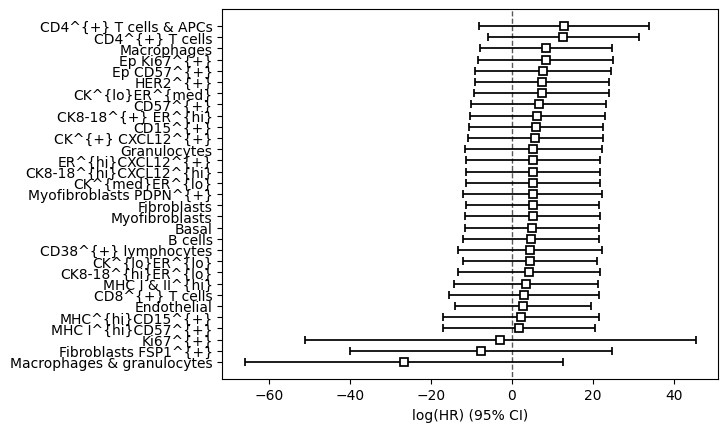

In [85]:
cph.plot();

<Axes: >

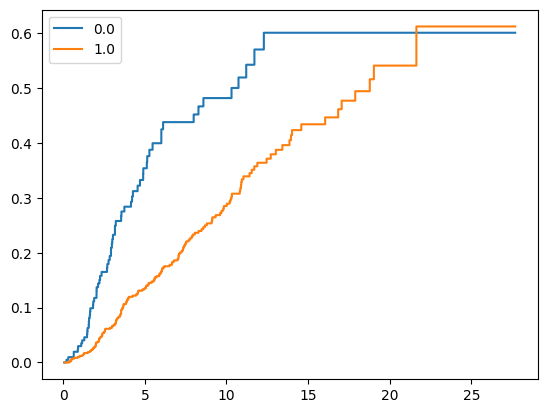

In [86]:
cph.baseline_cumulative_hazard_.plot(drawstyle="steps")